<a href="https://colab.research.google.com/github/jjungmini/-/blob/main/%EB%82%B4%EA%BA%BC%2Blstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV


In [101]:
# 데이터 로딩
df = pd.read_excel('데이터_선형보간법_ver1.xlsx')

# 날짜를 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

In [102]:
df.columns

Index(['Date', 'YY', 'MM', 'DD', 'HH', 'AC_출력_1', 'AC_출력_2', 'solarpower',
       'Temp_air', 'Precipitation', 'Windspeed', 'Humidity', 'Pressure_air',
       'Sunshine', 'Insolation', 'Snow', 'Cloudcover', 'Temp_ground', 'PM10',
       'PM25'],
      dtype='object')

In [103]:
df.info()
# 발전소 데이터의 결측치를 0으로 채우기
df[['AC_출력_1', 'AC_출력_2', 'solarpower']] = df[['AC_출력_1', 'AC_출력_2', 'solarpower']].fillna(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28464 entries, 0 to 28463
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           28464 non-null  datetime64[ns]
 1   YY             28464 non-null  int64         
 2   MM             28464 non-null  int64         
 3   DD             28464 non-null  int64         
 4   HH             28464 non-null  int64         
 5   AC_출력_1        13218 non-null  float64       
 6   AC_출력_2        13046 non-null  float64       
 7   solarpower     13563 non-null  float64       
 8   Temp_air       28464 non-null  float64       
 9   Precipitation  28464 non-null  float64       
 10  Windspeed      28464 non-null  float64       
 11  Humidity       28464 non-null  float64       
 12  Pressure_air   28464 non-null  float64       
 13  Sunshine       28464 non-null  float64       
 14  Insolation     28464 non-null  float64       
 15  Snow           2846

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28464 entries, 0 to 28463
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           28464 non-null  datetime64[ns]
 1   YY             28464 non-null  int64         
 2   MM             28464 non-null  int64         
 3   DD             28464 non-null  int64         
 4   HH             28464 non-null  int64         
 5   AC_출력_1        28464 non-null  float64       
 6   AC_출력_2        28464 non-null  float64       
 7   solarpower     28464 non-null  float64       
 8   Temp_air       28464 non-null  float64       
 9   Precipitation  28464 non-null  float64       
 10  Windspeed      28464 non-null  float64       
 11  Humidity       28464 non-null  float64       
 12  Pressure_air   28464 non-null  float64       
 13  Sunshine       28464 non-null  float64       
 14  Insolation     28464 non-null  float64       
 15  Snow           2846

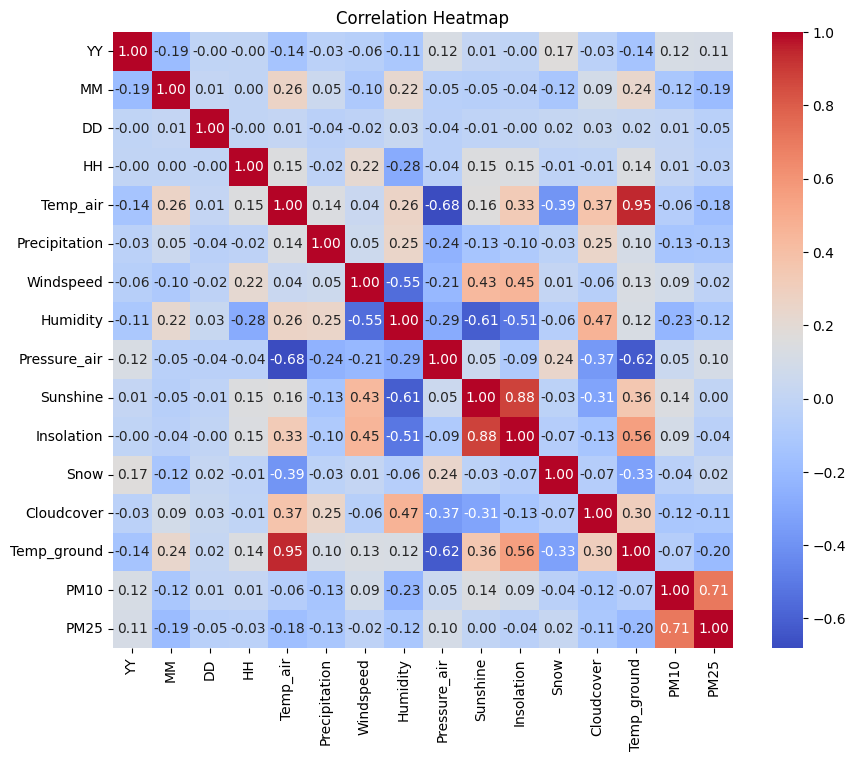

In [105]:
# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = MinMaxScaler()
df['solarpower'] = target_scaler.fit_transform(df[['solarpower']])
df['AC_출력_1'] = target_scaler.fit_transform(df[['AC_출력_1']])
df['AC_출력_2'] = target_scaler.fit_transform(df[['AC_출력_2']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = MinMaxScaler()

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외
correlation_matrix = df.drop(columns=['Date', 'solarpower', 'AC_출력_1', 'AC_출력_2']).corr()

# Solarpower 제외하고 정규화
features = df.drop(columns=['Date', 'solarpower', 'AC_출력_1', 'AC_출력_2'])
scaled_features = scaler.fit_transform(features)
df[features.columns] = scaled_features

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [106]:
# 훈련 데이터와 테스트 데이터로 분리
train = df[df['Date'] < '2023-01-01']
test = df[(df['Date'] >= '2023-01-01') & (df['Date'] < '2023-04-01')]

In [107]:
# 훈련 데이터를 이용하여 특성 선택을 위한 ElasticNetCV 모델을 생성합니다
enet_train = ElasticNetCV(
    alphas=[0.001, 0.01, 0.1, 1, 10],        # 후보 alpha 값 리스트
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],     # 후보 l1_ratio 값 리스트
    cv=5,                                   # 5-fold cross-validation 사용
    n_alphas=1000,                           # 100개의 alpha 값 생성
    max_iter=1000,                          # 최대 반복 횟수
    tol=1e-4,                               # 수렴 기준
    verbose=False,                          # 로그 출력 비활성화
    precompute='auto',                      # 자동으로 사전 계산된 Gram 행렬 결정
    selection='random',                      # 랜덤하게 특성 선택
    random_state=42
)
enet_train.fit(train.drop(columns=['Date', 'solarpower', 'AC_출력_1', 'AC_출력_2']), train['solarpower'])
# alpha 값을 출력합니다.
print('Best alpha: ', enet_train.alpha_)

# 선택된 특성만 남김
selected_features_train = train.drop(columns=['Date', 'solarpower', 'AC_출력_1', 'AC_출력_2']).columns[enet_train.coef_ != 0]
train = train[['Date', 'solarpower', 'AC_출력_1', 'AC_출력_2', 'PM10', 'PM25'] + selected_features_train.tolist()]

# 선택된 특성 출력
print("Selected features: ", selected_features_train.tolist())

Best alpha:  0.001
Selected features:  ['YY', 'MM', 'HH', 'Temp_air', 'Humidity', 'Sunshine', 'Insolation']


In [108]:
test = test[['Date', 'solarpower', 'AC_출력_1', 'AC_출력_2', 'PM10', 'PM25'] + selected_features_train.tolist()]

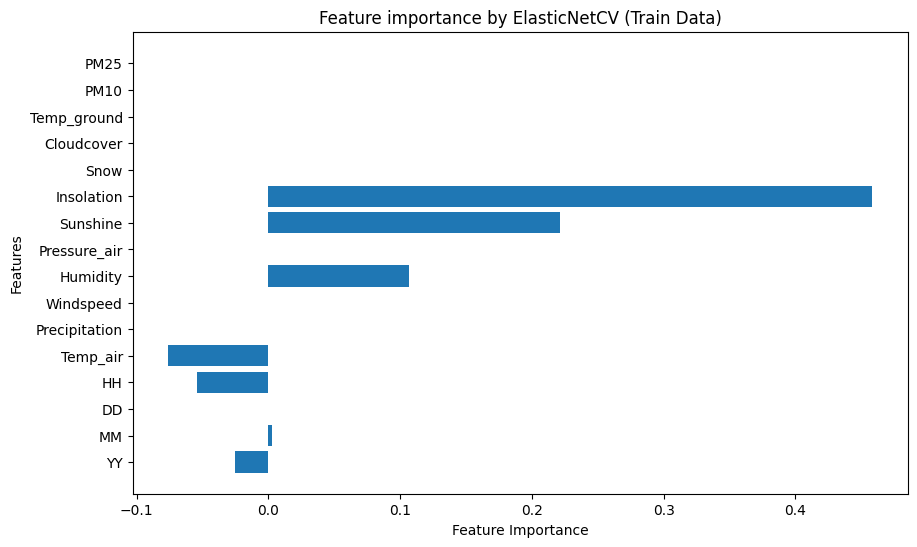

In [109]:
# ElasticNetCV의 결과를 출력합니다.
# 특성 중요도를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(range(len(enet_train.coef_)), enet_train.coef_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.yticks(range(len(enet_train.coef_)), enet_train.feature_names_in_)
plt.title('Feature importance by ElasticNetCV (Train Data)')
plt.show()

In [110]:
train

,Date,solarpower,AC_출력_1,AC_출력_2,PM10,PM25,YY,MM,HH,Temp_air,Humidity,Sunshine,Insolation
0,2020-01-01 00:00:00,0.0,0.0,0.0,0.023810,0.018583,0.000000,0.0,0.000000,0.222176,0.359730,0.0,0.0
1,2020-01-01 01:00:00,0.0,0.0,0.0,0.023088,0.017422,0.000000,0.0,0.043478,0.230534,0.423757,0.0,0.0
2,2020-01-01 02:00:00,0.0,0.0,0.0,0.022367,0.019744,0.000000,0.0,0.086957,0.238334,0.453243,0.0,0.0
3,2020-01-01 03:00:00,0.0,0.0,0.0,0.019481,0.017422,0.000000,0.0,0.130435,0.241677,0.500421,0.0,0.0
4,2020-01-01 04:00:00,0.0,0.0,0.0,0.019481,0.019744,0.000000,0.0,0.173913,0.244045,0.529065,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2022-12-31 19:00:00,0.0,0.0,0.0,0.057720,0.062718,0.666667,1.0,0.826087,0.356735,0.607414,0.0,0.0
26300,2022-12-31 20:00:00,0.0,0.0,0.0,0.056277,0.067364,0.666667,1.0,0.869565,0.344338,0.629318,0.0,0.0
26301,2022-12-31 21:00:00,0.0,0.0,0.0,0.060606,0.060395,0.666667,1.0,0.913043,0.339323,0.638585,0.0,0.0
26302,2022-12-31 22:00:00,0.0,0.0,0.0,0.060606,0.067364,0.666667,1.0,0.956522,0.338905,0.642797,0.0,0.0


In [111]:
# 훈련 데이터에서 특성과 타겟 변수 선택
X_train, y_train = train.drop(columns=['Date', 'solarpower',  'AC_출력_1', 'AC_출력_2']), train[['solarpower','AC_출력_1', 'AC_출력_2']]

# LSTM에 입력할 형태로 데이터 변환
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))

In [112]:
# 하이퍼파라미터 설정
units = 100           # LSTM 뉴런 수
activation = 'tanh'   # 활성화 함수
recurrent_activation = 'hard_sigmoid'  # 순환 활성화 함수
use_bias = True       # 바이어스 사용 여부
kernel_initializer = 'glorot_uniform'  # 가중치 행렬 초기화 방법
recurrent_initializer = 'orthogonal'   # 순환 가중치 행렬 초기화 방법
bias_initializer = 'zeros'             # 바이어스 초기화 방법
unit_forget_bias = True                # forget 게이트의 바이어스 초기화 여부
dropout = 0.2         # 입력 유닛 드롭아웃 비율
recurrent_dropout = 0.2  # 순환 상태 드롭아웃 비율
return_sequences = False  # 출력이 모든 시퀀스에 대한 출력인지 여부
return_state = False      # 출력에 상태 정보 포함 여부
go_backwards = False      # 입력 시퀀스를 역방향으로 처리 여부
stateful = False          # 상태가 배치 간에 유지 여부
unroll = False            # 네트워크를 풀링하여 더 빠르게 실행 여부

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(units=units,
               activation=activation,
               recurrent_activation=recurrent_activation,
               use_bias=use_bias,
               kernel_initializer=kernel_initializer,
               recurrent_initializer=recurrent_initializer,
               bias_initializer=bias_initializer,
               unit_forget_bias=unit_forget_bias,
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               return_sequences=return_sequences,
               return_state=return_state,
               go_backwards=go_backwards,
               stateful=stateful,
               unroll=unroll,
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='linear', kernel_initializer='he_normal'))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam')

In [113]:
# 5-fold 교차 검증 수행
y_train = y_train['AC_출력_1']
tscv = TimeSeriesSplit(n_splits=10)
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

from keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 훈련
model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=24,
          validation_data=(X_val_fold, y_val_fold), verbose=2,
          callbacks=[early_stopping])


Epoch 1/30
997/997 - 10s - loss: 0.0265 - val_loss: 0.0229 - 10s/epoch - 10ms/step
Epoch 2/30
997/997 - 7s - loss: 0.0231 - val_loss: 0.0232 - 7s/epoch - 7ms/step
Epoch 3/30
997/997 - 5s - loss: 0.0217 - val_loss: 0.0238 - 5s/epoch - 5ms/step
Epoch 4/30
997/997 - 5s - loss: 0.0211 - val_loss: 0.0219 - 5s/epoch - 5ms/step
Epoch 5/30
997/997 - 6s - loss: 0.0209 - val_loss: 0.0213 - 6s/epoch - 6ms/step
Epoch 6/30
997/997 - 5s - loss: 0.0205 - val_loss: 0.0232 - 5s/epoch - 5ms/step
Epoch 7/30
997/997 - 6s - loss: 0.0201 - val_loss: 0.0182 - 6s/epoch - 6ms/step
Epoch 8/30
997/997 - 6s - loss: 0.0195 - val_loss: 0.0212 - 6s/epoch - 6ms/step
Epoch 9/30
997/997 - 5s - loss: 0.0192 - val_loss: 0.0282 - 5s/epoch - 5ms/step
Epoch 10/30
997/997 - 6s - loss: 0.0187 - val_loss: 0.0236 - 6s/epoch - 7ms/step
Epoch 11/30
997/997 - 5s - loss: 0.0181 - val_loss: 0.0221 - 5s/epoch - 5ms/step
Epoch 12/30
997/997 - 6s - loss: 0.0177 - val_loss: 0.0255 - 6s/epoch - 6ms/step


In [114]:
# 테스트 데이터에 대한 예측 수행
X_test, y_test = test.drop(columns=['Date', 'solarpower', 'AC_출력_1', 'AC_출력_2']), test['AC_출력_1']
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_pred = model.predict(X_test)

# 예측된 값을 원래 스케일로 역변환
# y_pred = target_scaler.inverse_transform(y_pred)
# y_test = target_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

68/68 [==============================] - 0s 2ms/step


In [119]:
y_test = np.array(y_test).reshape(-1, 1)

In [120]:
# 평가 지표 계산
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
rmse = np.sqrt(mse)

# 평가 지표 출력
print("평균 제곱 오차 (MSE):", mse)
print("평균 절대 오차 (MAE):", mae)
print("결정 계수 (R2):", r2)
print("평균 절대 백분율 오차 (MAPE):", mape)
print("평균 제곱근 오차 (RMSE):", rmse)

평균 제곱 오차 (MSE): 0.011830133990889453
평균 절대 오차 (MAE): 0.07430513235971459
결정 계수 (R2): 0.7277868993840482
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 0.10876641940824132


In [ ]:
# 평가지표를 데이터프레임으로 저장
evaluations = pd.DataFrame({'variables': "기상", 'MSE':mse, 'MAE':mae, 'R2':r2, 'MAPE':mape, 'RMSE':rmse}, index=[0])
# 엑셀 파일로 저장
evaluations.to_excel('evaluations_기상.xlsx', index=False)

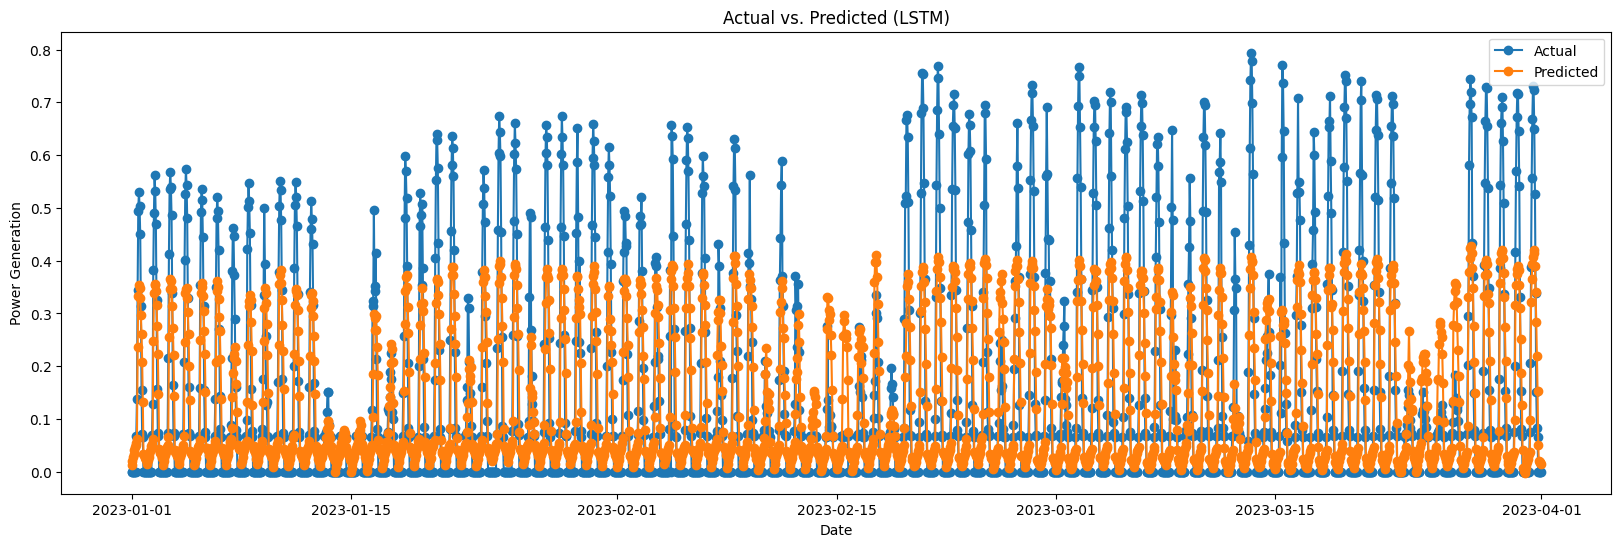

In [121]:
# 실제 값과 예측값 시각화
plt.figure(figsize=(20, 6))
plt.plot(test['Date'], y_test, label='Actual', marker='o')
plt.plot(test['Date'], y_pred, label='Predicted', marker='o')
plt.xlabel('Date')
plt.ylabel('Power Generation')
plt.title('Actual vs. Predicted (LSTM)')
plt.legend()
plt.show()

In [ ]:
# 예측값을 데이터프레임으로 변환
predictions_df = pd.DataFrame({'Date': test['Date'], 'Actual': y_test.flatten(), 'Predicted_기상': y_pred.flatten()})

# 엑셀 파일로 저장
predictions_df.to_excel('predictions_기상.xlsx', index=False)
